# Covid-19 Daily Reports

- This notebook downloads the data for the daily Covid-19 reports by state.
- These daily reports contain number of currently active, and in some cases, number of recovered cases, which are not available in the county-level data
- Active and recovered counts are needed for SIR models.

In [1]:
baseurl="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/"

In [341]:
import requests
from os.path import basename, isdir, isfile
from posix import mkdir
import sqlalchemy as sal
import pandas as pd
import datetime
import numpy as np

In [7]:
if not isdir("daily"):
    mkdir("daily")

In [349]:
#pandas daterange with index time span from first covid19 daily report
today=datetime.date.today()
yesterday=today - datetime.timedelta(days=1)
end_date=yesterday.strftime('%Y-%m-%d')
start_date='2020-04-22'
timespan=pd.date_range(start_date, end_date, freq="1D")
#(start_date, end_date, freq=)

In [345]:
datetime.timedelta(days=1)

datetime.timedelta(days=1)

In [350]:
filename=timespan[0].strftime('%Y-%m-%d.csv')

In [47]:
for day in timespan:
    filename=day.strftime('%m-%d-%Y.csv')
    url=baseurl + filename
    outfile="daily/" + filename
    #print(url, outfile)
    
    r=requests.get(url)

    print("\rDownloading %s" % filename, end="")
    with open (outfile, "wb") as fid:
        fid.write(r.content)

print(" done.")

In [88]:
#for day in timespan:
#    filename=day.strftime('daily/%m-%d-%Y.csv')
filename=timespan[0].strftime('daily/%m-%d-%Y.csv')

df=pd.read_csv(filename)
len(df)

59

In [387]:
endpoint = "capstone.clihskgj8i7s.us-west-2.rds.amazonaws.com"
user="group3"
db="db1"
#pw=getpass.getpass("Enter database password")
pw=open("/Users/daniel/Desktop/.awsdb","r").read().rstrip()

In [388]:
engine = sal.create_engine('postgresql://%s:%s@%s/%s' % (user, pw, endpoint, db))

In [405]:
popul_query="""
select province_state as state, cast(sum(population) as int) as population
from covidlocs
group by province_state
"""
population=pd.read_sql(popul_query, engine, index_col="state", )
population.loc["California",:]

In [151]:
#us states in json format
!curl -O https://gist.githubusercontent.com/mshafrir/2646763/raw/8b0dbb93521f5d6889502305335104218454c2bf/states_hash.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1388  100  1388    0     0  12504      0 --:--:-- --:--:-- --:--:-- 12504


In [231]:
import json
statenames=json.load(open("states_hash.json","r"))

statecodes={}
for name,code in zip(stateabbr.values(), stateabbr.keys()):
    statecodes[name.lower()] = code
    
#making up 'state codes' for these entries
statecodes["recovered"] = "REC"
statecodes["diamond princess"] = "DP"
statecodes["grand princess"] = "GP"

def lookup_statecode(name):
    if name.lower() in statecodes.keys():
        code=statecodes[name.lower()]
    else:
        print(name)
        code="N/A"
    return code

In [414]:
def get_covidlocs(indf):
    CovidLocs=indf.iloc[:,0:16]
    cols=list(CovidLocs.columns.str.lower())
    cols[3] = "latitude"
    cols[4] = "longitude"
    CovidLocs.columns=cols

    #CovidLocs.set_index("uid", drop=True, inplace=True)

    # set zero latitudes and longitudes also to none 
    for col in ["latitude","longitude"]:
        mask=CovidLocs[col] == 0.0
        CovidLocs.loc[mask,col] = np.nan
        
    #drop every column that is not static from the locations dataframe
    cols_to_drop=["country_region",
              "last_update",
              "confirmed",
              "deaths",
              "recovered",
              "active",
              "incident_rate",
              "people_tested",
              "people_hospitalized",
              "mortality_rate"]
    CovidLocs.drop(columns=cols_to_drop, inplace=True)
    
    CovidLocs["State"] = CovidLocs["province_state"].apply(lookup_statecode)
        
    CovidLocs.set_index("State", drop=True, inplace=True)
    return CovidLocs

In [415]:
covidlocs=get_covidlocs(df)
covidlocs.head()

,province_state,latitude,longitude,fips,uid,iso3
State,,,,,,
AL,Alabama,32.3182,-86.9023,1.0,84000001,USA
AK,Alaska,61.3707,-152.4044,2.0,84000002,USA
AS,American Samoa,-14.2710,-170.1320,60.0,16,ASM
AZ,Arizona,33.7298,-111.4312,4.0,84000004,USA
AR,Arkansas,34.9697,-92.3731,5.0,84000005,USA


In [422]:
#adding population to table
popul_query="""
select province_state, cast(sum(population) as int) as population
from covidlocs
group by province_state
"""
population=pd.read_sql(popul_query, engine)
population.query("province_state == 'California'")

,province_state,population
53,California,39512223.0


In [423]:
population["State"] = population["province_state"].apply(lookup_statecode)
population.set_index(["State"], inplace=True)
population.head(n=2)

,province_state,population
State,,
VI,Virgin Islands,107268.0
VT,Vermont,623989.0


In [424]:
covidlocs["population"] = population["population"]

In [425]:
allcols=df.columns
for n,col in enumerate(allcols):
    print("%d:%s" % (n,col))

0:Province_State
1:Country_Region
2:Last_Update
3:Lat
4:Long_
5:Confirmed
6:Deaths
7:Recovered
8:Active
9:FIPS
10:Incident_Rate
11:People_Tested
12:People_Hospitalized
13:Mortality_Rate
14:UID
15:ISO3
16:Testing_Rate
17:Hospitalization_Rate
18:date
19:State


In [351]:
usecols=[0,2,5,6,7,8,10,11,12,13,14,16,17]
alldfs=[]

for day in timespan:
    filename=day.strftime('daily/%m-%d-%Y.csv')
    if isfile(filename):
        ndf=pd.read_csv(filename, usecols=usecols)
        ndf["Date"] = day
        ndf["State"] = ndf["Province_State"].apply(lookup_statecode)
        ndf.drop(columns=["Province_State"], inplace=True)
        ndf.set_index("State", inplace=True)
        alldfs.append(ndf)
    else:
        print("%s not found, skipping." % filename)

cases=pd.concat(alldfs)
cases.reset_index(inplace=True)

In [352]:
#rearrainging columns
cols=cases.columns.tolist()
#for n,col in enumerate(cols):
#    print(n,col)
newcols=[]
newcols.append(cols[0])
newcols.append(cols[13])
for col in cols[2:13]:
    newcols.append(col)
newcols.append(cols[1])
cases=cases[newcols]

In [353]:
cases.head()

,State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,Testing_Rate,Hospitalization_Rate,Last_Update
0,AL,2020-04-22,5692,196,NaN,5397.0,119.281784,48760.0,730.0,3.504380,84000001.0,1039.903414,13.052029,2020-04-22 23:40:26
1,AK,2020-04-22,335,9,196.0,326.0,56.043590,12159.0,39.0,2.686567,84000002.0,2034.131383,11.641791,2020-04-22 23:40:26
2,AS,2020-04-22,0,0,NaN,NaN,0.000000,3.0,NaN,NaN,16.0,5.391708,NaN,2020-04-22 23:40:26
3,AZ,2020-04-22,5473,231,1265.0,5242.0,75.191823,56601.0,664.0,4.220720,84000004.0,777.623309,12.132286,2020-04-22 23:40:26
4,AR,2020-04-22,2276,42,863.0,2234.0,87.909473,29713.0,291.0,1.845343,84000005.0,1147.651222,12.785589,2020-04-22 23:40:26


In [376]:
scases=cases.query("State == 'WA'").sort_values(by="Date")

In [386]:
scases=cases.query("State == 'TX'").sort_values(by="Date")
scases.set_index("Date", drop=True, inplace=True)
scases.head()

,State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,Testing_Rate,Hospitalization_Rate,Last_Update
Date,,,,,,,,,,,,,
2020-04-22,TX,21577,596,7341.0,20765.0,92.762268,216783.0,1678.0,2.607758,84000048.0,943.167894,7.870175,2020-04-22 23:40:26
2020-04-23,TX,22797,645,8025.0,22046.0,98.544410,225078.0,1649.0,2.666667,84000048.0,979.257337,7.280353,2020-04-24 03:33:00
2020-04-24,TX,23772,663,9156.0,23018.0,102.860350,242547.0,1674.0,2.639371,84000048.0,1055.260529,7.080619,2020-04-25 06:32:46
2020-04-25,TX,24287,678,9986.0,23515.0,105.083582,262816.0,1597.0,2.641494,84000048.0,1143.445811,6.612015,2020-04-26 02:32:45
2020-04-26,TX,25051,699,10763.0,24316.0,108.625090,276021.0,1542.0,2.607442,84000048.0,1200.897420,6.176153,2020-04-27 02:32:46


In [ ]:
def get_sir(indf):
    sirdf=pd.DataFrame(index=indf.index())

<AxesSubplot:xlabel='Date'>

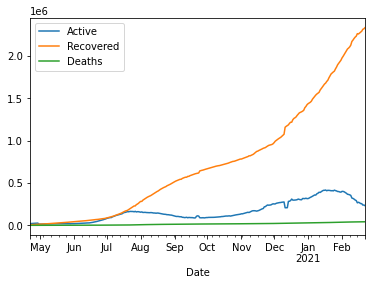

In [385]:
ax=scases.plot(x="Date", y="Active")
scases.plot(x="Date", y="Recovered", ax=ax)
scases.plot(x="Date", y="Deaths", ax=ax)